In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from os import listdir
from sklearn.preprocessing import StandardScaler
import umap
from matplotlib_venn import venn2, venn3
from functions import volcano, annot_volcano

In [33]:
# lcms_raw = pd.read_csv('../data/metabolome/lcms.csv')
# lcms_raw = lcms_raw.dropna(subset=['HMDB ID','KEGG ID'], how='all').reset_index().drop(['index'],axis=1)
# lipids = ['PA','PS','PE','PG','PC','PI','CP','CL','SM','DG','TG',
#           'LPE','LPA','LPS','LPG','LPC','LPI','PIP','PGP','CDP-DG',
#           'DGDG','SQDG','LysoPA','LysoPE','LysoPC','LysoPS','LysoPI']
# compound_names = []
# for cmp in list(lcms_raw['Compound']):
#     if cmp[:6] in lipids:
#         compound_names.append(cmp[:6])
#     elif cmp[:4]in lipids:
#         compound_names.append(cmp[:4])
#     elif cmp[:3]in lipids:
#         compound_names.append(cmp[:3])
#     elif cmp[:2] in lipids:
#         compound_names.append(cmp[:2])
#     else:
#         compound_names.append( cmp.split('|')[0].split('CollisionEnergy')[0].strip() )
# lcms_raw['Compound'] = compound_names
# lcms_raw = lcms_raw.drop(['HMDB ID','KEGG ID'],axis=1)
# lcms_raw = lcms_raw.set_index(['Compound'])
# lcms_raw = lcms_raw.groupby(lcms_raw.index, axis=0).sum()
# lcms_avg = pd.DataFrame( lcms_raw.mean(axis=1) ,columns=['Avg'])
# lcms_avg = lcms_avg.sort_values(by=['Avg'],ascending=False)
# top100_mets = list( lcms_avg.index)[:100]
# lcms_raw = lcms_raw.loc[top100_mets]
# lcms_raw.to_csv('../data/metabolome/lcms_top100.csv')

# Differential analysis for oral metabolites

In [2]:
# from pydeseq2.dds import DeseqDataSet
# from pydeseq2.default_inference import DefaultInference
# from pydeseq2.ds import DeseqStats

In [3]:
# lcms = pd.read_csv('../data/metabolome/lcms_top100.csv')
# lcms = lcms.rename(columns={'Compound':'Sample'})
# lcms = lcms.set_index(['Sample'])
# meta = pd.DataFrame(zip(list(lcms.columns), ['A' for i in range(10)] + ['B' for i in range(10)] ), 
#                     columns=['Sample','Group'])
# meta = meta.set_index('Sample')
# for k in lcms.columns:
#     temp = [ int(x*1e5) for x in list(lcms[k]) ]
#     lcms[k] = temp
# lcms = lcms.T

# inference = DefaultInference()
# dds = DeseqDataSet( counts= lcms, metadata= meta,
#     design_factors="Group", refit_cooks=True,ref_level= ["Group", "A"], inference=inference )

In [4]:
# dds.deseq2()
# print(dds)

In [5]:
# diffanalysis = DeseqStats(dds,contrast= ['Group', 'B', 'A'], inference=inference)
# diffanalysis.summary()

In [6]:
# diffanalysis.results_df.to_csv("../data/metabolome/met_deg.csv")

In [2]:
met_deg = pd.read_csv('../data/metabolome/met_deg.csv')
met_deg = met_deg.rename(columns={'Sample':'Metabolite'})
met_deg = met_deg[met_deg['log2FoldChange']>-6]
met_deg = met_deg.dropna()

In [7]:
# lfc_col='log2FoldChange'; x_cut1=2.0;x_cut2=-2.0;pv_col='padj';pv_cutoff=0.001;
# table = met_deg
# sig_table = table[ ( (table[lfc_col]>x_cut1) | (table[lfc_col]<x_cut2) ) & (table[pv_col]<pv_cutoff)  ]
# sig_table = sig_table.sort_values(['log2FoldChange'],ascending=False)
# sig_table = sig_table.reset_index().drop(['index'],axis=1)

(-5.0, 6.0)

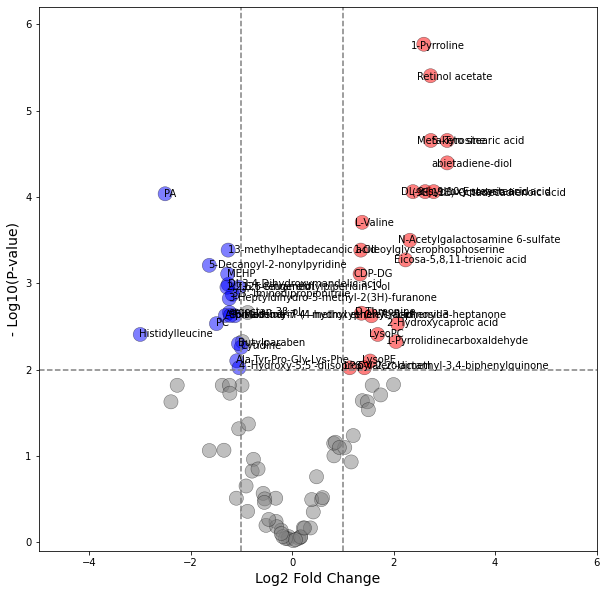

In [3]:
fig, ax = plt.subplots(figsize=(10,10))
volcano( met_deg, 'log2FoldChange', 'padj', 1.0, 0.01, 200, ax=ax)
ax.set_xlabel('Log2 Fold Change',fontsize=14)
ax.set_ylabel('- Log10(P-value)',fontsize=14)
annot_volcano( met_deg,'Metabolite' ,'log2FoldChange', 'padj', 1.0, 0.01, 10, ax=ax );
ax.set_ylim([-0.1,6.2]); ax.set_xlim([-5,6])

# UMAP

In [4]:
lcms = pd.read_csv('../data/metabolome/lcms_top100.csv')
lcms = lcms.rename(columns={'Compound':'Sample'})
lcms = lcms.set_index(['Sample'])
lcms = lcms.T
threshold = pd.read_csv('../data/metagenome/Thresholds.csv')
threshold =threshold.set_index(['Sample'])
threshold = threshold.reindex(list(lcms.index))

In [7]:
X = lcms.iloc[:,:].values
X = StandardScaler().fit_transform(X)
reducer_met = umap.UMAP(random_state=0)
embedding = reducer_met.fit_transform(X)
umap_pd = pd.DataFrame(embedding, columns =['UMAP-1','UMAP-2'])
umap_pd['Group'] = ['A (20~30yr)' for i in range(10)] + ['B (55~80yr)' for i in range(10)]

/home/bras5181/miniconda3/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


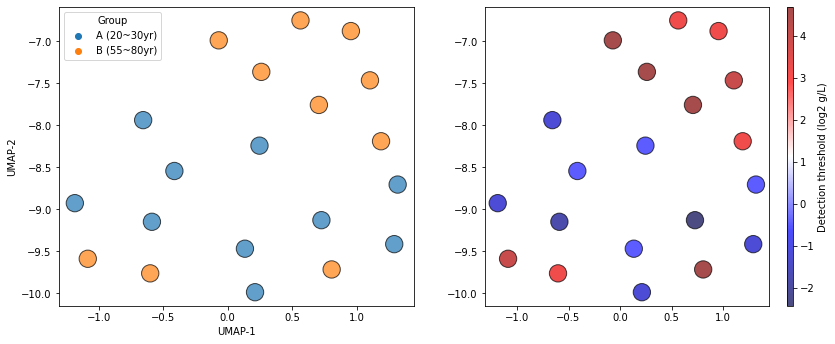

In [8]:
fig, axs = plt.subplots(1,2,figsize=(14,5.5))
sns.scatterplot(x='UMAP-1', y='UMAP-2',hue="Group",
            linewidth=1,data=umap_pd, s=300, alpha=0.7, edgecolor='black', ax=axs[0])
pt1=axs[1].scatter( umap_pd['UMAP-1'], umap_pd['UMAP-2'], c=np.log2(threshold['Detection threshold']), 
                   cmap='seismic',alpha=0.7,s=300, edgecolor='black')
plt.colorbar(pt1, label='Detection threshold (log2 g/L)', aspect=50)